#1. ReAct Agent (LangGraph)
Made by: Wilfredo Aaron Sosa Ramos

In [1]:
!pip install -q langchain langchain_core langchain_community langgraph langchain_google_genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.1 MB/s eta 0:00:00


In [2]:
import os
from google.colab import userdata

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = userdata.get(var)

_set_env("GOOGLE_API_KEY")

In [3]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

@tool
def get_gdp(country: str):
    """
    Retrieves the latest GDP data for a specified country.
    """
    # Placeholder implementation
    # For demonstration purposes only
    dummy_gdp_data = {
        "usa": "21 trillion USD",
        "china": "14 trillion USD",
        "japan": "5 trillion USD",
        "germany": "4 trillion USD"
    }
    return dummy_gdp_data.get(country.lower(), f"No data available for {country}")

@tool
def calculate_inflation(base_price: float, current_price: float):
    """
    Calculates the inflation rate given a base price and a current price.
    Returns the inflation rate as a percentage.
    """
    # Placeholder calculation for demonstration
    if base_price <= 0:
        return "Invalid base price."
    inflation_rate = ((current_price - base_price) / base_price) * 100
    return f"The inflation rate is {inflation_rate:.2f}%"

@tool
def get_economic_indicators(country: str):
    """
    Provides various economic indicators (e.g., unemployment rate, interest rate)
    for a given country.
    """
    # Placeholder implementation
    indicators = {
        "usa": {"unemployment_rate": "3.5%", "interest_rate": "5.0%"},
        "china": {"unemployment_rate": "5.5%", "interest_rate": "3.7%"},
        "japan": {"unemployment_rate": "2.6%", "interest_rate": "-0.1%"}
    }
    return indicators.get(country.lower(), f"No indicators available for {country}")

@tool
def list_kpis_for_sector(sector: str):
    """
    Lists common KPIs for a given economic or industrial sector.
    """
    # Placeholder lists of KPIs
    sector_kpis = {
        "retail": ["Same-Store Sales", "Average Transaction Value", "Customer Retention Rate"],
        "manufacturing": ["Overall Equipment Effectiveness", "Unit Production Cost", "Cycle Time"],
        "technology": ["Monthly Active Users", "Customer Acquisition Cost", "Churn Rate"],
        "healthcare": ["Bed Occupancy Rate", "Patient Satisfaction Score", "Readmission Rate"]
    }
    return sector_kpis.get(sector.lower(), f"No KPIs available for {sector}")

@tool
def get_financial_ratios(company: str):
    """
    Retrieves basic financial ratios (e.g., P/E ratio, ROE) for a specified company.
    """
    # Placeholder implementation
    dummy_ratios = {
        "apple": {"P/E Ratio": "25.4", "ROE": "87%"},
        "google": {"P/E Ratio": "30.1", "ROE": "17%"},
        "tesla": {"P/E Ratio": "50.2", "ROE": "12%"}
    }
    return dummy_ratios.get(company.lower(), f"No data available for {company}")

tools = [
    get_gdp,
    calculate_inflation,
    get_economic_indicators,
    list_kpis_for_sector,
    get_financial_ratios
]

model = model.bind_tools(tools)

In [5]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}


# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with state_modifier, but is a lot more flexible
    system_prompt = SystemMessage(
        "You are a helpful AI assistant, please respond to the users query to the best of your ability!"
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

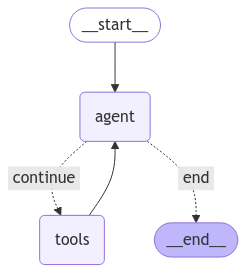

In [6]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
def print_stream(stream):
  for s in stream:
      message = s["messages"][-1]
      if isinstance(message, tuple):
          print(message)
      else:
          message.pretty_print()

In [8]:
inputs = {"messages": [("user", "Retrieve the GDP of the USA and China, and compare the unemployment rates and interest rates of these countries. Then, calculate the inflation rate in the USA based on a base price of $100 and a current price of $120.")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Retrieve the GDP of the USA and China, and compare the unemployment rates and interest rates of these countries. Then, calculate the inflation rate in the USA based on a base price of $100 and a current price of $120.
================================== Ai Message ==================================
Tool Calls:
  get_gdp (f5b4d720-9fae-4f7b-84a9-05bc913185cf)
 Call ID: f5b4d720-9fae-4f7b-84a9-05bc913185cf
  Args:
    country: USA
  get_gdp (8c549daf-a291-4095-8ae6-83551af5e361)
 Call ID: 8c549daf-a291-4095-8ae6-83551af5e361
  Args:
    country: China
  get_economic_indicators (7ab0e71c-8e22-4ec6-a839-71f5c04ec42c)
 Call ID: 7ab0e71c-8e22-4ec6-a839-71f5c04ec42c
  Args:
    country: USA
  get_economic_indicators (35996223-83e0-4876-ae62-3b6d0ff55277)
 Call ID: 35996223-83e0-4876-ae62-3b6d0ff55277
  Args:
    country: China
  calculate_inflation (4bdd58f1-148a-43e4-9993-3bc33206aa56)
 Call ID: 4bdd58f1-148a-43

In [9]:
inputs = {"messages": [("user", "List the key performance indicators (KPIs) for the retail and technology sectors. Using these KPIs, identify metrics suitable for evaluating the performance of a leading company in each sector.")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

List the key performance indicators (KPIs) for the retail and technology sectors. Using these KPIs, identify metrics suitable for evaluating the performance of a leading company in each sector.
================================== Ai Message ==================================
Tool Calls:
  list_kpis_for_sector (ea6b27ae-776f-438d-835e-4fd119470f60)
 Call ID: ea6b27ae-776f-438d-835e-4fd119470f60
  Args:
    sector: retail
  list_kpis_for_sector (c4d053f5-2e69-4495-93ec-e3986ff93202)
 Call ID: c4d053f5-2e69-4495-93ec-e3986ff93202
  Args:
    sector: technology
================================= Tool Message =================================
Name: list_kpis_for_sector

["Monthly Active Users", "Customer Acquisition Cost", "Churn Rate"]
================================== Ai Message ==================================

Okay, here are the KPIs for the retail and technology sectors, and some suitable metrics for eva

In [10]:
inputs = {"messages": [("user", "Fetch the financial ratios for Tesla and Apple, then analyze the differences in their P/E ratios and ROEs. Discuss how these differences reflect on their respective market strategies and investor appeal.")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Fetch the financial ratios for Tesla and Apple, then analyze the differences in their P/E ratios and ROEs. Discuss how these differences reflect on their respective market strategies and investor appeal.
================================== Ai Message ==================================
Tool Calls:
  get_financial_ratios (e14d4718-cf26-450b-8fe4-3250c2d0dec4)
 Call ID: e14d4718-cf26-450b-8fe4-3250c2d0dec4
  Args:
    company: Tesla
  get_financial_ratios (633a5dc6-def8-4cfb-b0b3-874ed2b5f5a6)
 Call ID: 633a5dc6-def8-4cfb-b0b3-874ed2b5f5a6
  Args:
    company: Apple
================================= Tool Message =================================
Name: get_financial_ratios

{"P/E Ratio": "25.4", "ROE": "87%"}
================================== Ai Message ==================================

Okay, I've fetched the financial ratios for both Tesla and Apple.

Tesla:
*   P/E Ratio: 50.2
*   ROE: 12%

Apple:
*   P/E

In [11]:
inputs = {"messages": [("user", "Retrieve economic indicators for Japan and calculate how changes in interest rates and unemployment rates might influence the technology sector's KPIs, particularly focusing on Monthly Active Users and Customer Acquisition Cost.")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Retrieve economic indicators for Japan and calculate how changes in interest rates and unemployment rates might influence the technology sector's KPIs, particularly focusing on Monthly Active Users and Customer Acquisition Cost.
================================== Ai Message ==================================
Tool Calls:
  get_economic_indicators (d205ed4c-43fd-455e-84a6-d0ed5fda8684)
 Call ID: d205ed4c-43fd-455e-84a6-d0ed5fda8684
  Args:
    country: Japan
================================= Tool Message =================================
Name: get_economic_indicators

{"unemployment_rate": "2.6%", "interest_rate": "-0.1%"}
================================== Ai Message ==================================

Okay, I have the current interest rate (-0.1%) and unemployment rate (2.6%) for Japan.

Changes in these indicators can indeed influence the technology sector's KPIs like Monthly Active Users (MAU) and Custo

In [12]:
inputs = {"messages": [("user", "Calculate the inflation rate for a base price of $50 and a current price of $65. Then, assess how such inflation levels could impact KPIs in the manufacturing sector, including Overall Equipment Effectiveness and Unit Production Cost, in Germany.")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Calculate the inflation rate for a base price of $50 and a current price of $65. Then, assess how such inflation levels could impact KPIs in the manufacturing sector, including Overall Equipment Effectiveness and Unit Production Cost, in Germany.
================================== Ai Message ==================================
Tool Calls:
  calculate_inflation (56987f90-cf30-409c-808a-b2f2c3c1770c)
 Call ID: 56987f90-cf30-409c-808a-b2f2c3c1770c
  Args:
    current_price: 65.0
    base_price: 50.0
  list_kpis_for_sector (d2b68ae8-136e-4ac7-9c23-ccfc6d627805)
 Call ID: d2b68ae8-136e-4ac7-9c23-ccfc6d627805
  Args:
    sector: manufacturing
================================= Tool Message =================================
Name: list_kpis_for_sector

["Overall Equipment Effectiveness", "Unit Production Cost", "Cycle Time"]
================================== Ai Message ==================================

The infla